In [ ]:
import tensorflow as tf
import datetime, os

In [1]:
tf.config.list_physical_devices('GPU')

NameError: name 'tf' is not defined

In [19]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
import pickle
from tensorflow.keras.optimizers import RMSprop

In [4]:
path = '1661-0.txt'
text = open(path).read().lower()
print('length of the corpus is :', len(text))

length of the corpus is : 581888


In [5]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
words = tokenizer.tokenize(text)

In [6]:
print(words[0:10])

['\ufeff', 'project', 'gutenberg', "'s", 'the', 'adventures', 'of', 'sherlock', 'holmes', ',']


In [7]:
unique_words = np.unique(words)
unique_word_index = dict((c,i) for i,c in enumerate(unique_words))

In [8]:
## Feature Engineering
WORD_LENGTH = 5
next_words = []
prev_words = []

for i in range(len(words)-WORD_LENGTH):
    prev_words.append(words[i:i+WORD_LENGTH])
    next_words.append(words[i+WORD_LENGTH])
    
print(prev_words[1])
print(next_words[1])

['project', 'gutenberg', "'s", 'the', 'adventures']
of


In [9]:
X = np.zeros((len(prev_words),WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)

for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
        Y[i, unique_word_index[next_words[i]]] = 1

In [10]:
#np.zeros((5,5,8), dtype=bool)

In [11]:
#np.zeros((2,8), dtype=bool)

In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [16]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

Epoch 1/2
918/918 [==============================] - 27s 28ms/step - loss: 3.0639 - accuracy: 0.5933 - val_loss: 9.4461 - val_accuracy: 0.0786
Epoch 2/2
918/918 [==============================] - 25s 27ms/step - loss: 2.9320 - accuracy: 0.6137 - val_loss: 9.7910 - val_accuracy: 0.0788


In [17]:
model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

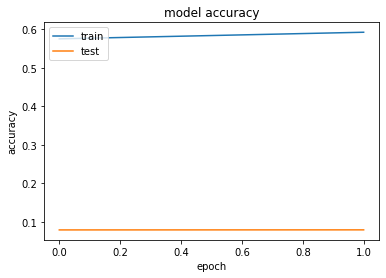

In [23]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

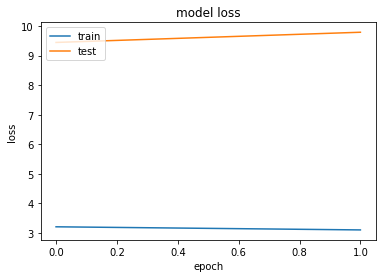

In [21]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [49]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        x[0, t, unique_word_index[word]] = 1.
    return x

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [54]:
# def predict_completions(text, n=3):

#     x = prepare_input(text)

#     preds = model.predict(x, verbose=0)[0]

#     next_indices = sample(preds, n)

#     return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion
        
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [55]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [56]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 


IndexError: index 5 is out of bounds for axis 1 with size 5